# 3.2 线性回归从零实现

In [80]:
%matplotlib inline

import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random


## 3.2.1 生成数据集

构建一个简单的数据集，样本数量为1000，特征数为2，给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [81]:
# 生成数据集

num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)

# 生成标签
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

# 标签添加噪点
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

print(features[0], labels[0])


tensor([1.1956, 1.4984]) tensor(1.4992)


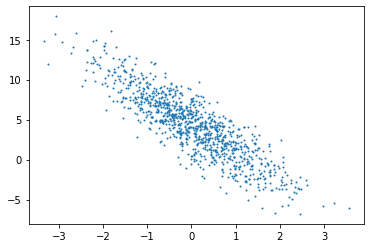

In [82]:
# 生成第二特征与标签的散点图，观察两者线性关系

def use_svg_display():
    # 用矢量图表示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize 

# set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)


## 3.2.2 读取数据   

在训练模型时，我们需要遍历数据并且不断读取小批量数据(`batch_size`)样本。

In [83]:
# 定义函数，每次返回 batch_size (批量大小) 个随机样本的特征和标签
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本读取顺序随机

    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)

In [84]:
batch_size = 10 # 批量大小

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.1918, -0.2667],
        [ 0.0527,  0.4740],
        [-0.7084, -0.9268],
        [ 0.1298, -0.2697],
        [-0.6294,  1.3820],
        [-0.1512,  0.3797],
        [-1.4522,  0.8768],
        [-0.4570,  0.2279],
        [-1.3685, -0.7250],
        [-0.1251,  1.5288]]) tensor([ 5.4783,  2.6890,  5.9246,  5.3849, -1.7699,  2.5959, -1.6967,  2.5086,
         3.9270, -1.2655])


## 3.2.3 初始化模型参数

我们将权重初始化成均值为0，标准差为0.01的正态随机数，偏差则初始化为0

In [85]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 之后的模型训练，需要对这些参数求梯度来迭代参数的值
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

# 3.2.4 定义模型


In [86]:
# 定义线性回归模型
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

使用平方损失来定义线性函数的损失函数。在实现中，需要把真实值`y`的形状变成预测值`y_hat`的形状。

In [87]:
def squared_loss(y_hat, y):
    # 注意这里返回的是向量，另外 pytorch 里的 MSELoss 并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

下面实现小批量的随机梯度下降算法，它通过不断迭代模型参数来优化损失函数。这里自动求导得到的梯度是一个批量样本的梯度和，我们将除以批量大小来得到平均。


In [88]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 3.2.7 训练模型

In [89]:
lr = 0.03 # 学习率
num_epochs = 3 # 迭代次数
net = linreg
loss = squared_loss

for epoch in range(num_epochs): # 训练模型一共需要 num_epochs 个迭代周期
    # 在每个迭代周期中，会使用训练数据集中所有样本一次
    # X 和 y 分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


tensor(0.0282, grad_fn=<MeanBackward0>)
epoch 1, loss 0.028237
tensor(9.8538e-05, grad_fn=<MeanBackward0>)
epoch 2, loss 0.000099
tensor(4.9924e-05, grad_fn=<MeanBackward0>)
epoch 3, loss 0.000050


In [94]:
# 对比真实参数和训练集的真实参数
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3998]], requires_grad=True)
4.2 
 tensor([4.1992], requires_grad=True)


In [91]:
y

tensor([ 2.6621e+00,  7.2587e+00,  8.4276e-01,  5.7052e+00,  4.6290e+00,
         7.2379e+00, -9.7190e-04,  5.5067e+00,  7.0017e+00,  6.6800e+00])